(250, 2)
(379, 2)
(369, 2)


Text(0.5, 1.0, 'Scatter of Isotropic and Correlated Gaussian Densities')

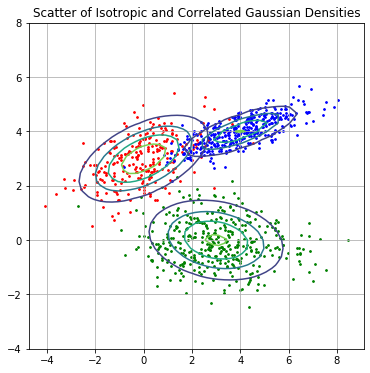

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import random
import re
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import preprocessing

def genGaussianSamples(N, m, C):
    A = np.linalg.cholesky(C)
    U = np.random.randn(N, 2)
    return (U @ A.T + m)


# 定义三种均值
#
Means = np.array([[0, 3], [3, 0], [4, 4]])

# 定义三个协方差矩阵，并保证他们是正定的
# 产生的是随机的堆成的正定矩阵
from sklearn.datasets import make_spd_matrix

CovMatrices = np.zeros((3, 2, 2))
for j in range(3):
    CovMatrices[j, :, :] = make_spd_matrix(2)

# 先验概率
#
w = np.random.rand(3)
w = w / np.sum(w)

# 每个部分有多少个样本（总共1000个）
#
nData = np.floor(w * 1000).astype(int)

# 从每个部分中提取样本
#
X0 = genGaussianSamples(nData[0], Means[0, :], CovMatrices[0, :, :])
X1 = genGaussianSamples(nData[1], Means[1, :], CovMatrices[1, :, :])
X2 = genGaussianSamples(nData[2], Means[2, :], CovMatrices[2, :, :])
print(X0.shape)
print(X1.shape)
print(X2.shape)
X = np.append(np.append(X0, X1, axis=0), X2, axis=0)


def gauss2D(x, m, C):
    Ci = np.linalg.inv(C)
    dC = np.linalg.det(C)
    num = np.exp(-0.5 * np.dot((x - m).T, np.dot(Ci, (x - m))))
    den = 2 * np.pi * dC

    return num / den


def twoDGaussianPlot(nx, ny, m, C):
    x = np.linspace(-4, 8, nx)
    y = np.linspace(-4, 8, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')  # 生成网格点坐标，索引为ij

    Z = np.zeros([nx, ny])
    for i in range(nx):
        for j in range(ny):
            xvec = np.array([X[i, j], Y[i, j]])
            Z[i, j] = gauss2D(xvec, m, C)

    return X, Y, Z


nx = 50
ny = 40
Xp0, Yp0, Zp0 = twoDGaussianPlot(nx, ny, Means[0, :], CovMatrices[0, :, :])
Xp1, Yp1, Zp1 = twoDGaussianPlot(nx, ny, Means[1, :], CovMatrices[1, :, :])
Xp2, Yp2, Zp2 = twoDGaussianPlot(nx, ny, Means[2, :], CovMatrices[2, :, :])

plt.figure(figsize=(6,6))
plt.contour(Xp0, Yp0, Zp0, 4)
plt.contour(Xp1, Yp1, Zp1, 4)
plt.contour(Xp2, Yp2, Zp2, 4)
plt.scatter(X0[:, 0], X0[:, 1], s=3, c='r')
plt.scatter(X1[:, 0], X1[:, 1], s=3, c='g')
plt.scatter(X2[:, 0], X2[:, 1], s=3, c='b')
plt.grid(True)
plt.title('Scatter of Isotropic and Correlated Gaussian Densities')


(177, 14)


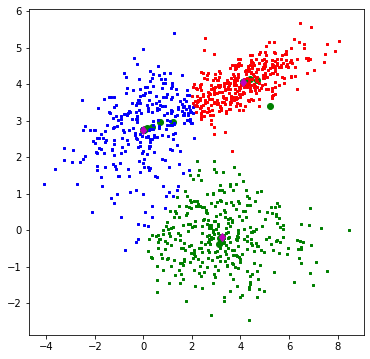

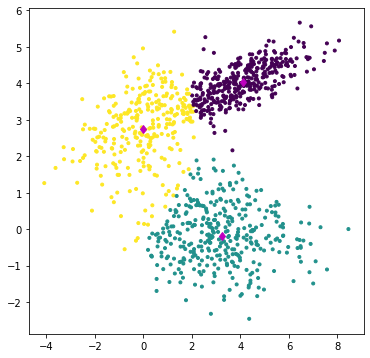

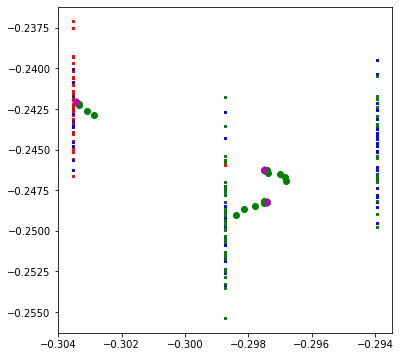

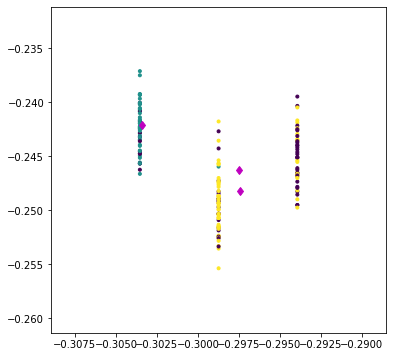

In [23]:
#
# k-means算法的中心部分
def calcuDistance(vec1, vec2):
    # 计算向量1与向量2之间的欧式距离
    return np.sqrt(np.sum(np.square(vec1 - vec2)))  # 注意这里的减号


def initCentroids(dataSet, k):
    # 从数据集中随机选取k个数据返回
    dataSet = list(dataSet)
    return random.sample(dataSet, k)


def minDistance(dataSet, centroidList):
    # 对每个属于dataSet的item， 计算item与centroidList中k个质心的距离，找出距离最小的，并将item加入相应的簇类中
    clusterDict = dict()  # dict保存簇类结果,创建一个字典
    k = len(centroidList)

    for item in dataSet:
        vec1 = item
        flag = -1
        minDis = float("inf")  # 初始化为最大值
        for i in range(k):
            vec2 = centroidList[i]
            distance = calcuDistance(vec1, vec2)  # error
            if distance < minDis:
                minDis = distance
                flag = i  # 循环结束时， flag保存与当前item最近的蔟标记
        if flag not in clusterDict.keys():
            clusterDict.setdefault(flag, [])
        clusterDict[flag].append(item)  # 加入相应的类别中
    return clusterDict  # 不同的类别


def getCentroids(clusterDict):
    # 重新计算k个质心
    centroidList = []
    for key in clusterDict.keys():
        centroid = np.mean(clusterDict[key], axis=0)
        centroidList.append(centroid)
    return centroidList  # 得到新的质心


def getVar(centroidList, clusterDict):
    # 计算各蔟集合间的均方误差
    # 将蔟类中各个向量与质心的距离累加求和
    sum = 0.0
    for key in clusterDict.keys():
        vec1 = centroidList[key]
        distance = 0.0
        for item in clusterDict[key]:
            vec2 = item
            distance += calcuDistance(vec1, vec2)
        sum += distance
    return sum


def test_k_means(dataSet):
    centroidList = initCentroids(dataSet, k)
    clusterDict = minDistance(dataSet, centroidList)
    # # getCentroids(clusterDict)
    # showCluster(centroidList, clusterDict)
    newVar = getVar(centroidList, clusterDict)
    oldVar = 1  # 当两次聚类的误差小于某个值是，说明质心基本确定。

    times = 2
    while abs(newVar - oldVar) >= 0.00001:
        centroidList = getCentroids(clusterDict)
        clusterDict = minDistance(dataSet, centroidList)
        oldVar = newVar
        newVar = getVar(centroidList, clusterDict)
        times += 1
        showCluster(centroidList, clusterDict)
    for i in clusterDict.keys():
        plt.plot(centroidList[i][0], centroidList[i][1],'dm',markersize = 6)
    



def showCluster(centroidList, clusterDict):
    # 展示聚类结果
    colorMark = ['.r', '.b', '.g', '.k', ',y', ',w']  # 不同簇类标记，o表示圆形，另一个表示颜色
    centroidMark = ['og', 'og', 'og', 'og', 'og', 'og']

    for key in clusterDict.keys():
        #print("迭代次数:",key)
        plt.plot(centroidList[key][0], centroidList[key][1], centroidMark[key], markersize=6)# 质心点

        #plt.plot(centroidList[key][-1], centroidList[key][-1], 'om', markersize=6)
        for item in clusterDict[key]:
            plt.plot(item[0], item[1], colorMark[key], markersize=3)
    #a = [centroidList[0][0],centroidList[0][1]]
    #print(clusterDict)
    #plt.plot(centroidList[a][0], centroidList[a][-1],'om', markersize=6)



dataSet = X
k = 3
# initCentroids(dataSet,k)
# centroids,clusterAssement = KMeans(dataSet,k)
plt.figure(figsize=(6,6))
test_k_means(dataSet)



kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

Y = kmeans.fit_predict(X)
Z = kmeans.cluster_centers_

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=Y, marker='.')
plt.plot(Z[:, 0],Z[:, 1], 'dm', markersize = 6)

df = pd.read_csv("/Users/stay1ndr/Downloads/semesiter 1/machine learning/machine learning lab/wine.data")
print(df.shape)
wine = np.array(df)
#pre-processing
#zero mean
wine = (wine - np.mean(wine))/np.std(wine)

#print(wine)
k = 3
plt.figure(figsize=(6,6))
test_k_means(wine)

kmeans.fit(wine)
Y1 = kmeans.fit_predict(wine)
Z1 = kmeans.cluster_centers_

plt.figure(figsize=(6,6))
plt.scatter(wine[:, 0], wine[:, 1], c=Y1, marker='.')
plt.plot(Z1[:, 0],Z1[:, 1], 'dm', markersize = 6)

              5.1         3.5         1.4         0.2
count  149.000000  149.000000  149.000000  149.000000
mean     5.848322    3.051007    3.774497    1.205369
std      0.828594    0.433499    1.759651    0.761292
min      4.300000    2.000000    1.000000    0.100000
25%      5.100000    2.800000    1.600000    0.300000
50%      5.800000    3.000000    4.400000    1.300000
75%      6.400000    3.300000    5.100000    1.800000
max      7.900000    4.400000    6.900000    2.500000


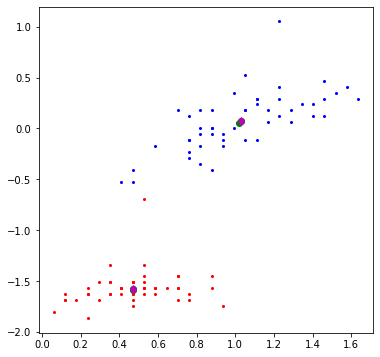

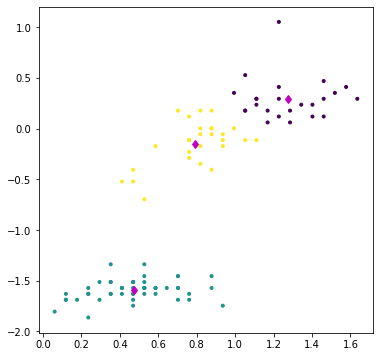

In [24]:
df = pd.read_csv("/Users/stay1ndr/Downloads/semesiter 1/machine learning/machine learning lab/iris.data")
print(df.describe())

y = df.iloc[50:150, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0,2]].values
Y1=X[:50]
Y2=X[50:100]
wine = np.concatenate((Y1,Y2))

#pre-processing
#zero mean
wine = (wine - np.mean(wine))/np.std(wine)

#print(wine)
k = 2
plt.figure(figsize=(6,6))
test_k_means(wine)

kmeans.fit(wine)
Y1 = kmeans.fit_predict(wine)
Z1 = kmeans.cluster_centers_

plt.figure(figsize=(6,6))
plt.scatter(wine[:, 0], wine[:, 1], c=Y1, marker='.')
plt.plot(Z1[:, 0],Z1[:, 1], 'dm', markersize = 6)
